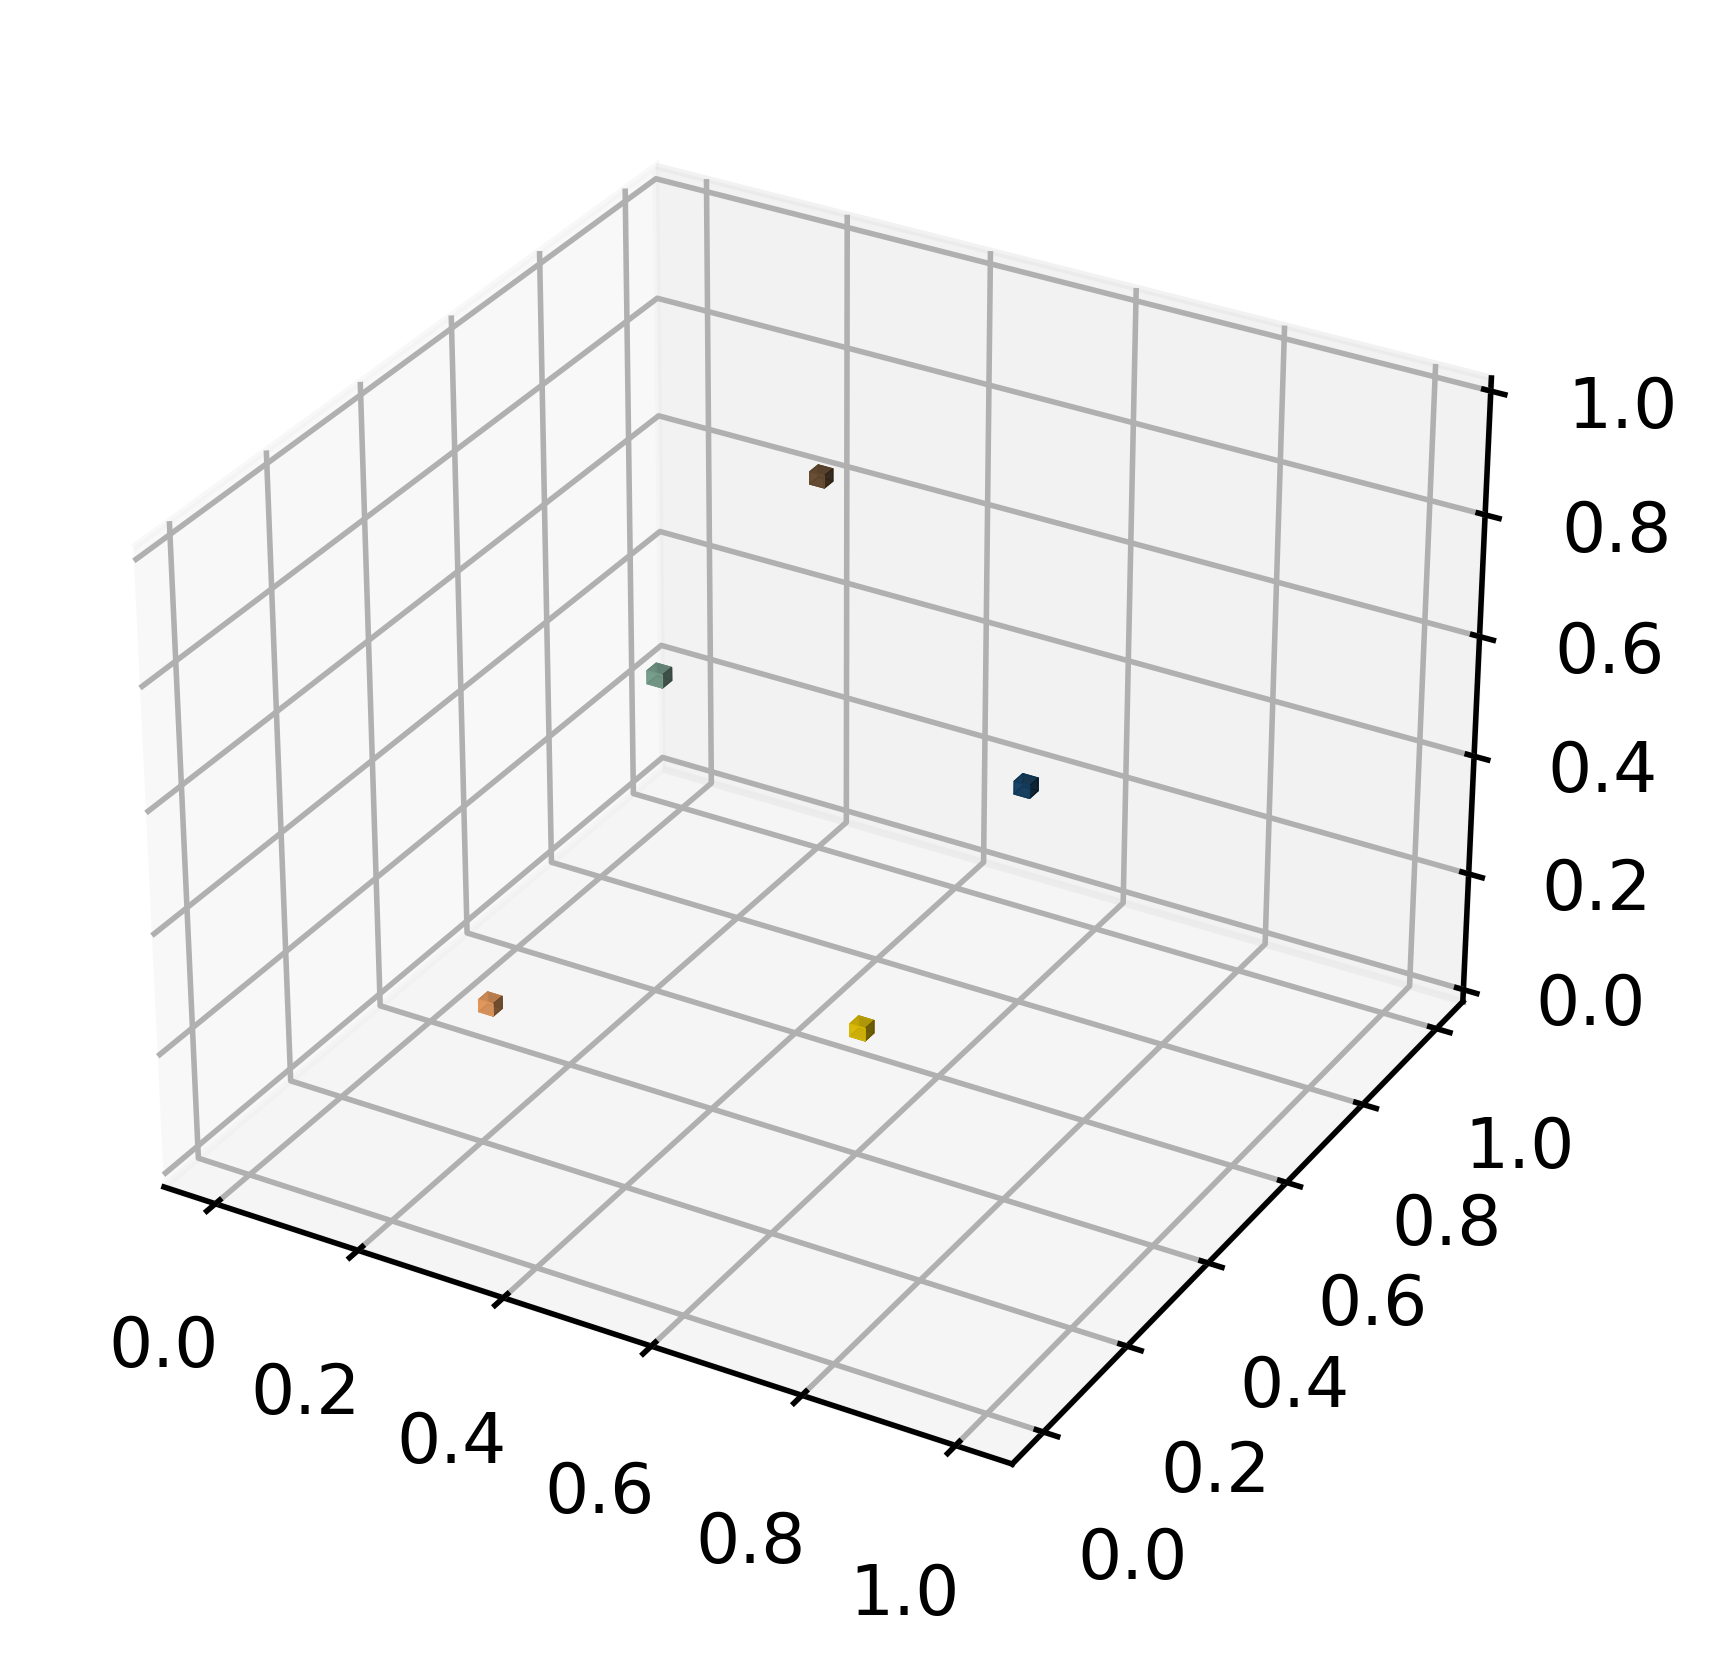

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


MAX_DIST = 1000000000

def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# 矢量点对应栅格坐标
def coor2grid(x,y,z,inter):
    i = np.floor(x/inter).astype("int32")
    j = np.floor(y/inter).astype("int32")
    k = np.floor(z/inter).astype("int32")
    return i,j,k

# 空间网格,分割份数为格子数+1
#x,y,z = np.mgrid[0:1:21j,0:1:21j,0:1:21j]
#cx,cy,cz = np.mgrid[0:1:21j,0:1:21j,0:0:21j]
x,y,z = np.mgrid[0:1:51j,0:1:51j,0:1:51j]
cx,cy,cz = np.mgrid[0:1:51j,0:1:51j,0:0:51j]
# 分割间隔
grid_inter = 1/(51-1)

#### 类似分配场,hsv对应颜色场前三维是空间网格位置
#### 第四维是RGB（原来用的hsv色彩空间，为了方便 名字没改）
# sphere 代表空间中目标是否绘制，True or False，除了生成元的位置，其余初始为0（False）
sphere = midpoints(cz)
# combine the color components
hsv = np.zeros(sphere.shape + (3,))
hsv[..., 0] = midpoints(cx)
hsv[..., 1] = midpoints(cy)
hsv[..., 2] = midpoints(cz)
#hsv[..., 3] = midpoints(ca)

#### 距离场
dist = np.zeros(sphere.shape)
dist[...] = midpoints(cx)

# 初始化
for i in range(x.shape[0]-1):
    for j in range(x.shape[1]-1):
        for k in range(x.shape[2]-1):
            hsv[i,j,k,0] = 1
            hsv[i,j,k,1] = 1
            hsv[i,j,k,2] = 1 #i/x.shape[0]
            sphere[i,j,k] = 0
            #hsv[i,j,k,3] = 0
            dist[i,j,k] = MAX_DIST


# and plot everything
# 可视化dpi
dpi = 500

fig = plt.figure(dpi=dpi)
ax = fig.gca(projection='3d')

# 随便选5个点
p_x = [0.2,0.5,0.75,0.35,0.85]
p_y = [0.2,0.1,0.15,0.75,0.35]
p_z = [0.2,0.9,0.4,0.8,0.7]
p_c = [(0.9961,0.6633,0.3961),
       (0.5137,0.6862,0.6078),
       (0.9568,0.8156,0),
       (0.4470,0.3254,0.2039),
       (0.0784,0.2667,0.4157)]
#0.05
p_i,p_j,p_k = coor2grid(np.array(p_x),np.array(p_y),np.array(p_z),grid_inter)
count = 0
# 初始化生成元的位置
for i,j,k in zip(p_i,p_j,p_k):
    
    hsv[i,j,k,0] = p_c[count][0]
    hsv[i,j,k,1] = p_c[count][1]
    hsv[i,j,k,2] = p_c[count][2]
    sphere[i,j,k] = 1
    dist[i,j,k] = 0
    count += 1
    
colors = hsv
# print(colors[colors!=1])

# ax.scatter(p_x,p_y,p_z,c = p_c,linewidth=0)
ax.voxels(x, y, z,sphere,
         facecolors=colors,
         #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
         edgecolors=colors,
         linewidth=0.2,alpha=0.8)

plt.show()

In [2]:
### 距离变换 最简单的3*3*3为例
# 构造模板
tempsize = [3,3,3]
#tempsize = [13,13,13]
dist_template = np.zeros(tempsize) 
for i in range(dist_template.shape[0]):
    for j in range(dist_template.shape[1]):
        for k in range(dist_template.shape[2]):
            dist_template[i,j,k] = ((i-tempsize[0]//2)**2 + (j-tempsize[1]//2)**2 + (k-tempsize[2]//2)**2)**0.5
flat_dist_template = dist_template.reshape(1,1,-1)
flat_dist_template_downhalf = np.zeros(tempsize).reshape(1,1,-1)
flat_dist_template_downhalf[0,0,flat_dist_template.shape[2]//2:] = flat_dist_template[0,0,flat_dist_template.shape[2]//2:]
dist_template_downhalf = flat_dist_template_downhalf.reshape(tempsize)

flat_dist_template[0,0,flat_dist_template.shape[2]//2+1:] = 0
dist_template_uphalf = flat_dist_template.reshape(tempsize)

dist_template_uphalf
flat_dist_template

array([[[1.73205081, 1.41421356, 1.73205081, 1.41421356, 1.        ,
         1.41421356, 1.73205081, 1.41421356, 1.73205081, 1.41421356,
         1.        , 1.41421356, 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]]])

In [355]:
# 开始距离变换
# 算法注释参考C++代码，原理相同
# first part
for i in range(sphere.shape[0]):
    for j in range(sphere.shape[1]-1,-1,-1):
        for k in range(sphere.shape[2]-1,-1,-1):
            distmin = MAX_DIST  #初始化最小距离
            locx = i
            locy = j 
            locz = k
            for t in range(dist_template.flatten().shape[0]//2+1):
                offx = t%tempsize[0]-1
                offy = t%(tempsize[0]*tempsize[1])//tempsize[0] - 1
                offz = t//(tempsize[0]*tempsize[1]) - 1
                templateDist = dist_template_uphalf.flatten()[t]
                CX = i+offx
                CY = j-offy
                CZ = k-offz
                if (CX < 0) or CX>(sphere.shape[0]-1):
                    continue
                if (CY < 0) or CY>(sphere.shape[0]-1):
                    continue
                if (CZ < 0) or CZ>(sphere.shape[0]-1):
                    continue
                if(np.abs(dist[CX,CY,CZ]-MAX_DIST)<0.00001):
                    continue
                if (dist[CX,CY,CZ]+templateDist) < distmin:
                    distmin = dist[CX,CY,CZ]+templateDist
                    locx = CX
                    locy = CY
                    locz = CZ
            dist[i,j,k] = distmin #为模板中心赋值最小距离
            hsv[i,j,k,0] = hsv[locx,locy,locz,0]
            hsv[i,j,k,1] = hsv[locx,locy,locz,1]
            hsv[i,j,k,2] = hsv[locx,locy,locz,2]
            if ~(hsv[i,j,k,0]==1 and hsv[i,j,k,1]==1 and hsv[i,j,k,2]==1):
                sphere[i,j,k] = 1

D:\Anaconda\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


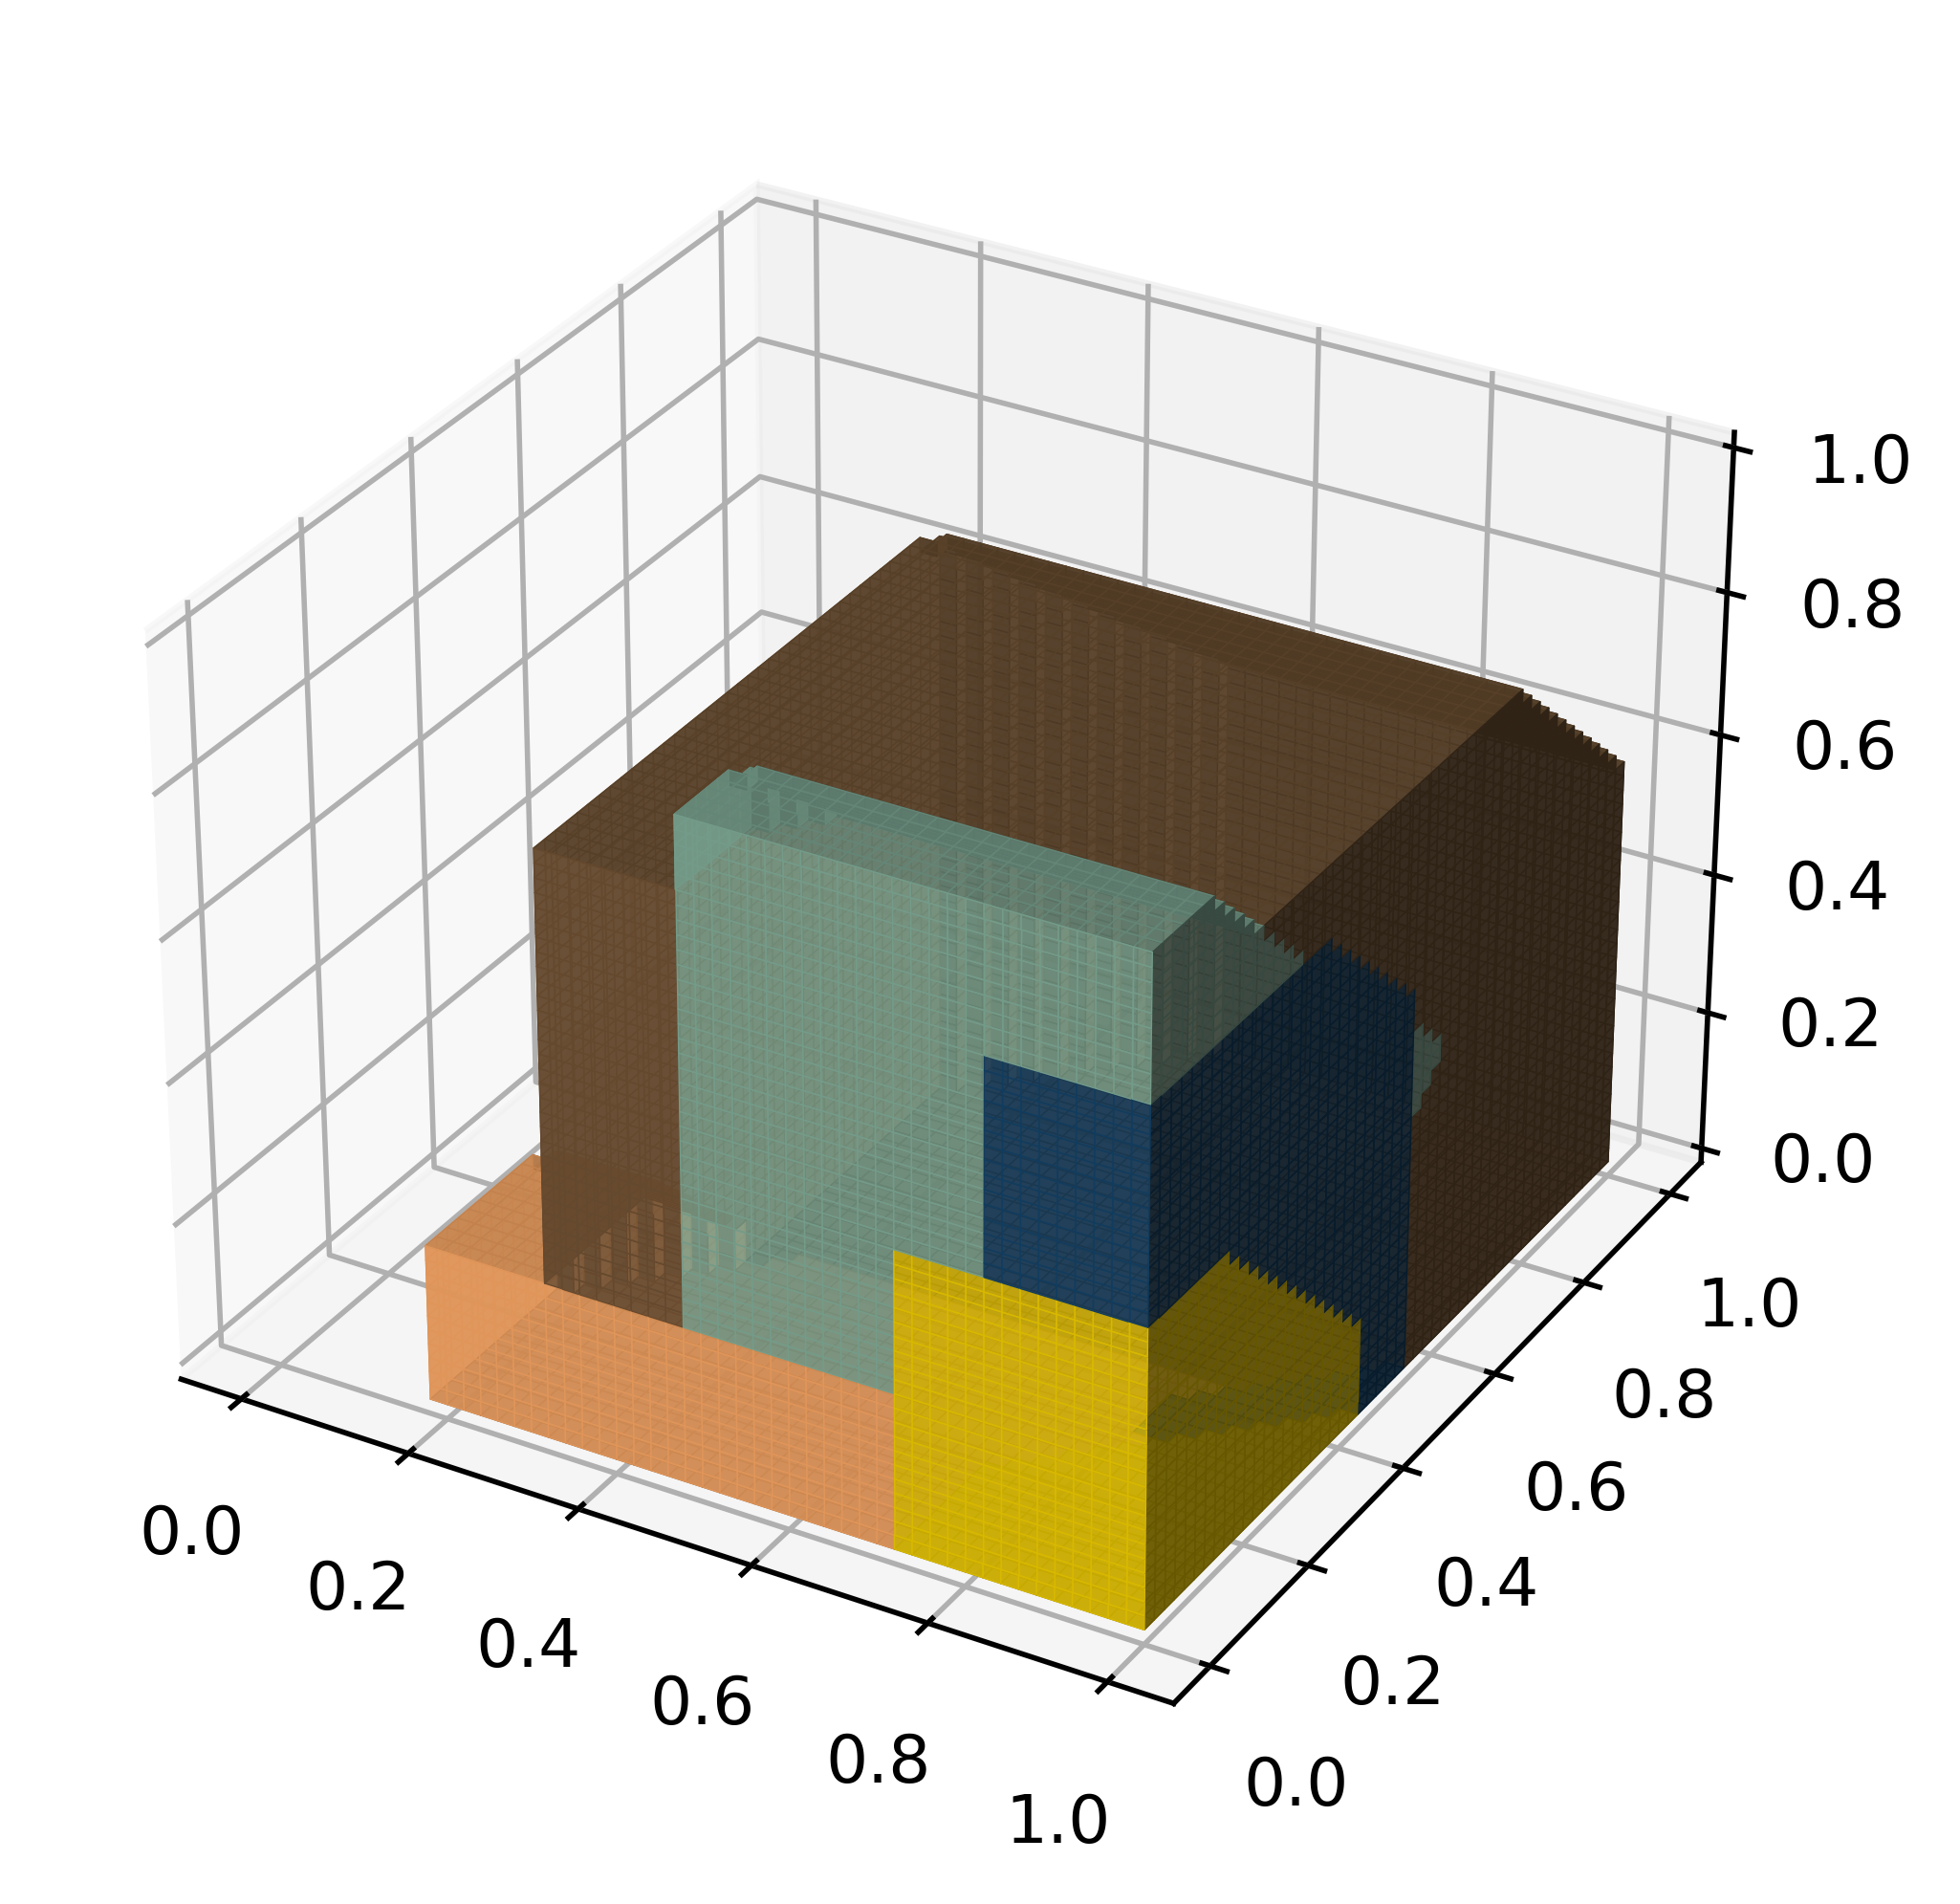

In [356]:
# 可视化距离变换一半的结果
fig_half = plt.figure(dpi=dpi)
ax_half = fig_half.gca(projection='3d')
colors = hsv
#print(colors[colors!=1])

#ax.scatter(p_x,p_y,p_z,c = p_c,linewidth=0)
ax_half.voxels(x, y, z,sphere,
         facecolors=colors,
         #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
         edgecolors=colors,
         linewidth=0.2,alpha=0.8)

plt.show()

In [357]:
# second part
for i in range(sphere.shape[0]-1,-1,-1):
    for j in range(sphere.shape[1]):
        for k in range(sphere.shape[2]):
            distmin = MAX_DIST  #初始化最小距离
            locx = i
            locy = j 
            locz = k
            for t in range(dist_template.flatten().shape[0]//2,dist_template.flatten().shape[0]):
                offx = t%tempsize[0]-1
                offy = t%(tempsize[0]*tempsize[1])//tempsize[0] - 1
                offz = t//(tempsize[0]*tempsize[1]) - 1
                templateDist = dist_template_downhalf.flatten()[t]
                CX = i+offx
                CY = j-offy
                CZ = k-offz
                if (CX < 0) or CX>(sphere.shape[0]-1):
                    continue
                if (CY < 0) or CY>(sphere.shape[0]-1):
                    continue
                if (CZ < 0) or CZ>(sphere.shape[0]-1):
                    continue
                if(np.abs(dist[CX,CY,CZ]-MAX_DIST)<0.00001):
                    continue
                if (dist[CX,CY,CZ]+templateDist) < distmin:
                    distmin = dist[CX,CY,CZ]+templateDist
                    locx = CX
                    locy = CY
                    locz = CZ
            dist[i,j,k] = distmin #为模板中心赋值最小距离
            hsv[i,j,k,0] = hsv[locx,locy,locz,0]
            hsv[i,j,k,1] = hsv[locx,locy,locz,1]
            hsv[i,j,k,2] = hsv[locx,locy,locz,2]
            if ~(hsv[i,j,k,0]==1 and hsv[i,j,k,1]==1 and hsv[i,j,k,2]==1):
                sphere[i,j,k] = 1


D:\Anaconda\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


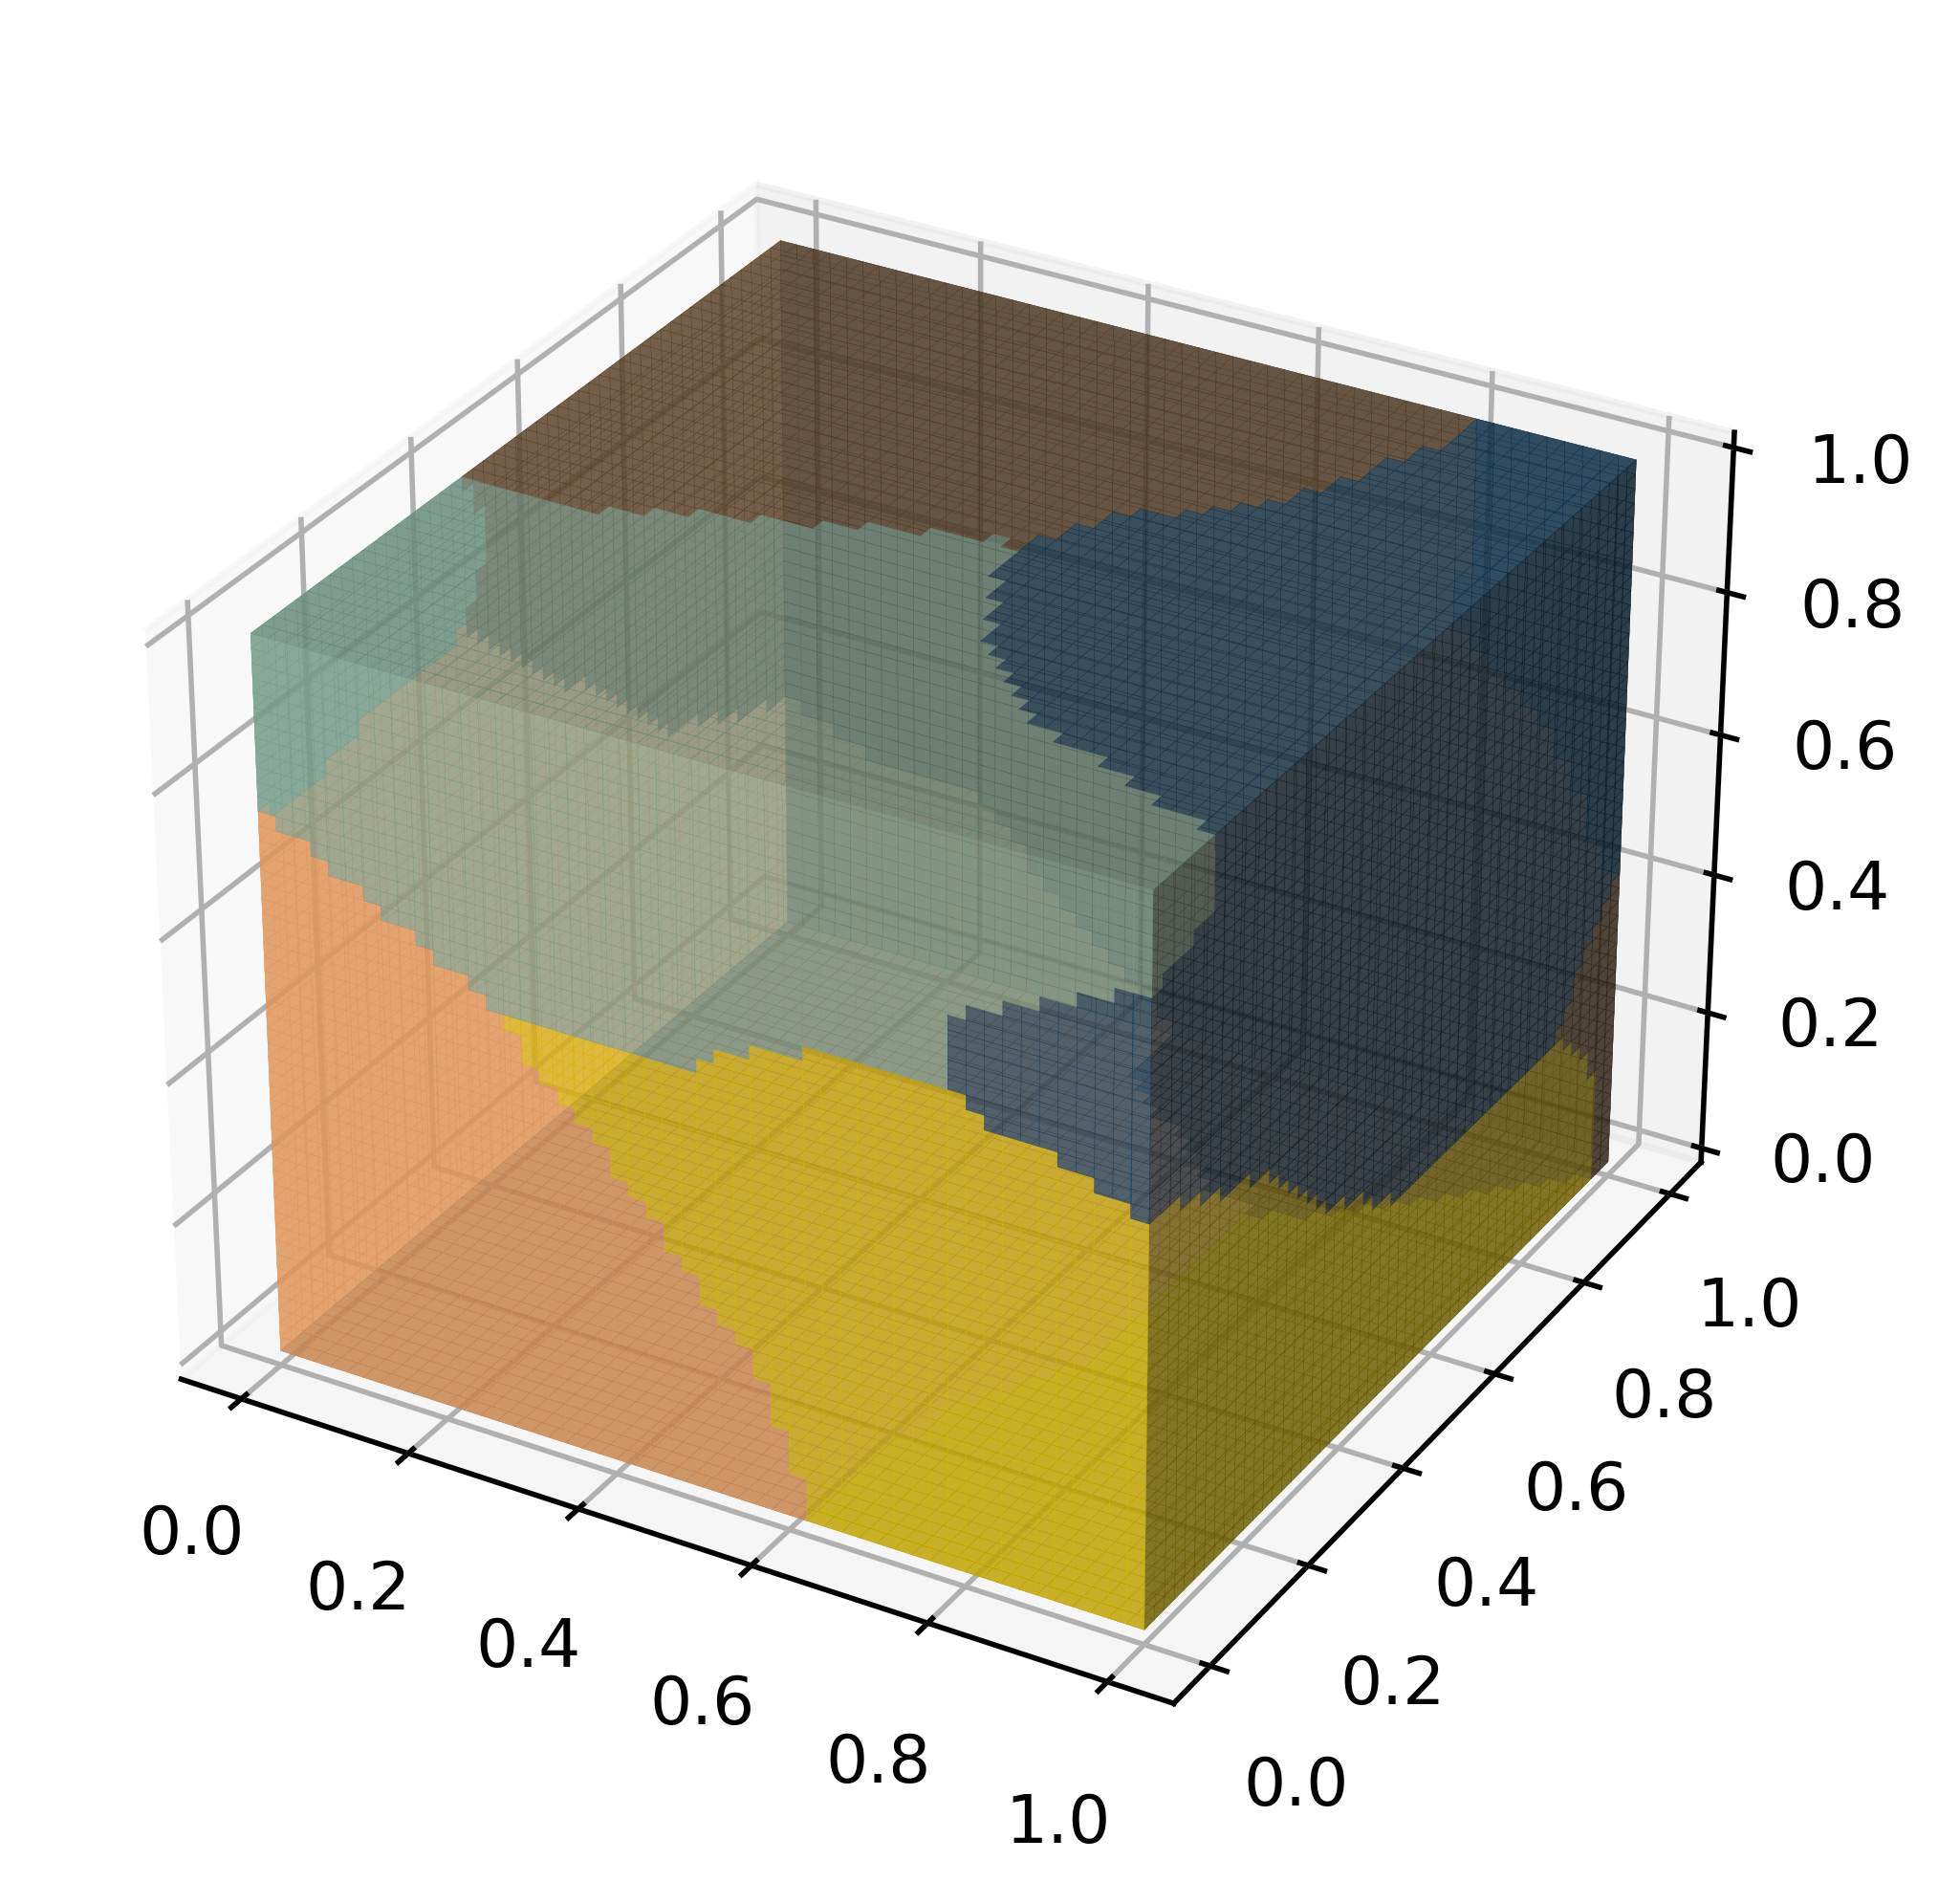

In [358]:
# 可视化分配场
fig2 = plt.figure(dpi=dpi)
ax2 = fig2.gca(projection='3d')
colors = hsv
#print(colors[colors!=1])

#ax.scatter(p_x,p_y,p_z,c = p_c,linewidth=0)
ax2.voxels(x, y, z,sphere,
         facecolors=colors,
         #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
         edgecolors=colors,
         linewidth=0.05,alpha=0.6)
plt.savefig("./loc.png")
plt.show()

D:\Anaconda\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


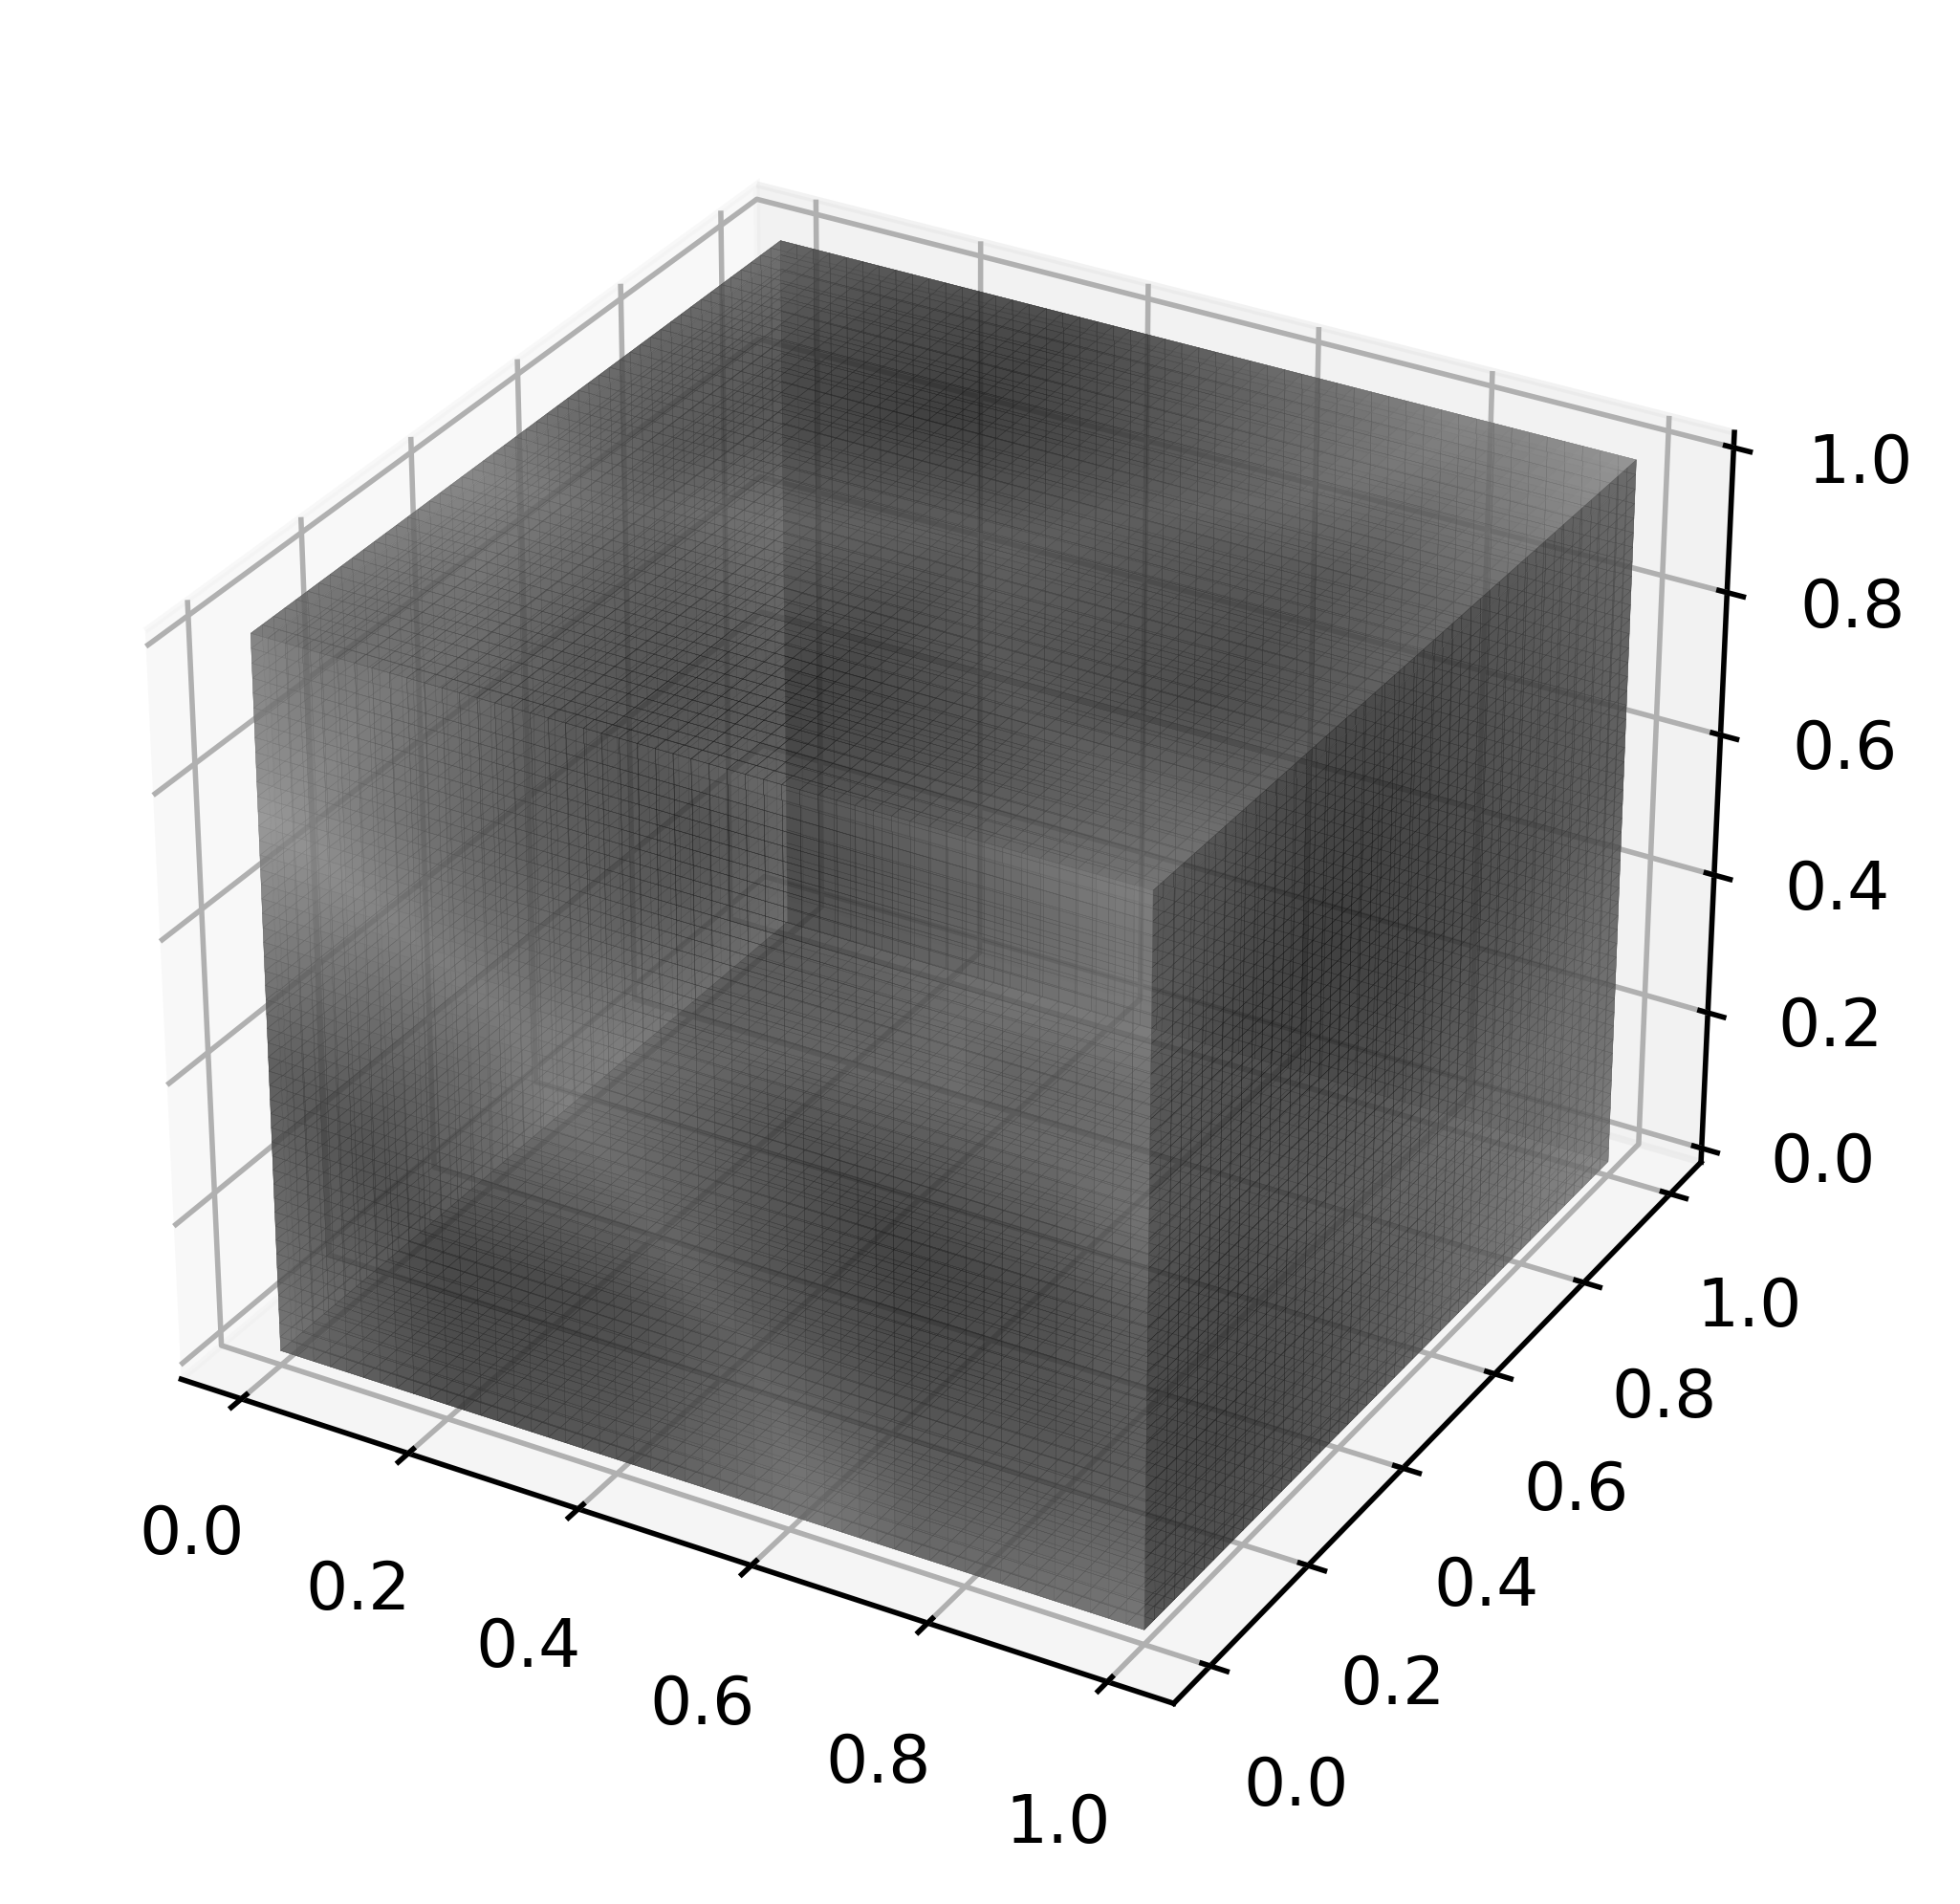

In [359]:
# 可视化距离场
fig3 = plt.figure(dpi=dpi)
ax3 = fig3.gca(projection='3d')
colors_dist = dist/np.max(dist)
colors_dist_z = np.zeros(colors_dist.shape + (3,))
colors_dist_z[...,0] = colors_dist
colors_dist_z[...,1] = colors_dist
colors_dist_z[...,2] = colors_dist
#print(colors[colors!=1])
#ax.scatter(p_x,p_y,p_z,c = p_c,linewidth=0)
ax3.voxels(x, y, z,sphere,
         facecolors=colors_dist_z,
         #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
         edgecolors=colors_dist_z,
         linewidth=0.05,alpha=0.6)
plt.savefig("./dist.png")
plt.show()
